In [18]:
import os
import pickle
from collections import Counter
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from joblib import Parallel,delayed
import warnings
warnings.filterwarnings('ignore')

def select_categories(data):
    categories = []
    for cat in data.category.unique():
        if data[data.category==cat].user.unique().shape[0]==data.user.unique().shape[0]:
            categories.append(cat)
    return categories

def remove_nonusers(df):
    if df.day.unique().shape[0] < minimum_day_per_user:
        return pd.DataFrame([],columns=df.columns)
    return df

unknown_category = 'Unknown'
start_hour = 5
end_hour  = 24
step = 1
one_minute = 60
day_minimum_threshold = 120
maximum_unknown_percentage = .25
minimum_day_per_user = 50

data = pickle.load(open('../data/activity_mperf_smartphone.p','rb'))
selected_categories = select_categories(data)
onehotencoder  = OneHotEncoder().fit(np.array([unknown_category]+selected_categories).reshape(-1,1))
category_dict = {a:i for i,a in enumerate(onehotencoder.categories_[0])}
data = data[data.category.isin(selected_categories)]
data = data.groupby('user',as_index=False).apply(remove_nonusers)

def parse_day_data(df):
    import warnings
    warnings.filterwarnings('ignore')
    if df['duration'].sum() < day_minimum_threshold or df['duration'].sum() < (end_hour-start_hour)*one_minute*(1-maximum_unknown_percentage):
        return pd.DataFrame([], columns = ['user', 'day', 'data'])
    user = df.user.values[0]
    day = df.day.values[0]
    df = df[(df.start_hour>=start_hour) & (df.start_hour<=end_hour)]
    start_time = pd.to_datetime(parser.parse(day))+timedelta(hours=start_hour)
    end_time = pd.to_datetime(parser.parse(day))+timedelta(hours=end_hour)
    df['start'] = df['start'].apply(lambda a:parser.parse(pd.to_datetime(a).strftime("%m/%d/%Y, %H:%M")))
    df['end'] = df['end'].apply(lambda a:parser.parse(pd.to_datetime(a).strftime("%m/%d/%Y, %H:%M")))
    df = df.sort_values('start').reset_index(drop=True)
    input_data = []
    initial = start_time
    for i,row in df.iterrows():
        if row['start']!=initial:
            n = (row['start']-initial).total_seconds()//one_minute
            input_data.extend([unknown_category]*int(n))
            initial += timedelta(minutes=n)
        n = (row['end']-initial).total_seconds()//one_minute
        input_data.extend([row['category']]*int(n))
        initial += timedelta(minutes=n)
    n = (end_time-initial).total_seconds()//one_minute
    input_data.extend([unknown_category]*int(n))
    
    input_data_final = onehotencoder.transform(np.array(input_data).reshape(-1,1)).toarray().reshape(1,-1,len(category_dict))
    return pd.DataFrame([[user,day,input_data_final]],columns=['user','day','data'])

data_final = pd.concat(Parallel(n_jobs=-1,verbose=2)(delayed(parse_day_data)(df) for i,df in data.groupby(['user','day'],as_index=False)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 3984 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 6904 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 10464 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 14680 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 19536 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 24757 out of 24757 | elapsed:   27.6s finished


In [19]:
data_final.user.unique().shape

(346,)

In [179]:

# Counter(input_data),len(input_data)

(1, 1140, 4)

In [164]:
# df.groupby('category').sum()
1140/60

19.0

(array([24024.,  2233., 11453., 61528., 39618., 50533., 68539., 48893.,
        24274., 10980.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

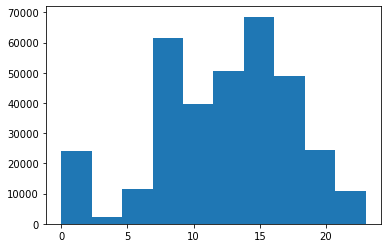

In [148]:
import matplotlib.pyplot as plt
plt.hist(data['start_hour'].values)

In [81]:
(-start_time).total_seconds()/60

356.91209999999995

In [82]:
pd.to_datetime(df['start'].values[0])

Timestamp('2017-10-30 09:56:54.726000')

(346140, 11)